In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
from sklearn.preprocessing import MinMaxScaler

## Preprocess Data

#### Included with this lab are TSLA.csv, GOOGL.csv and DJI.csv files. Use Pandas to retrieve the dataset. 
#### Use only Open price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [2]:
tesla_stocks = pd.read_csv('GOOGL.csv')


In [3]:
tesla_stocks.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3697,2019-04-29,1280.510010,1296.969971,1271.709961,1296.199951,1296.199951,3618400
3698,2019-04-30,1190.630005,1200.979980,1183.000000,1198.959961,1198.959961,6658900
3699,2019-05-01,1197.500000,1199.250000,1171.680054,1173.319946,1173.319946,3717000
3700,2019-05-02,1172.599976,1179.380005,1158.329956,1166.510010,1166.510010,2254900
3701,2019-05-03,1177.410034,1191.400024,1173.550049,1189.550049,1189.550049,2078300


In [4]:
data_to_use_tesla = tesla_stocks['Open'].values


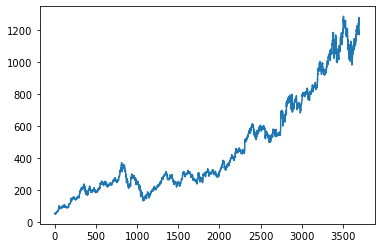

In [5]:
plt.plot(data_to_use_tesla)

## Normalize your data.

In [6]:
price = tesla_stocks[['Open']]

scaler = MinMaxScaler(feature_range=(-1,1))
price['Open']=scaler.fit_transform(price['Open'].values.reshape(-1,1))

<ipython-input-6-bea1ef9e32b3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Open']=scaler.fit_transform(price['Open'].values.reshape(-1,1))


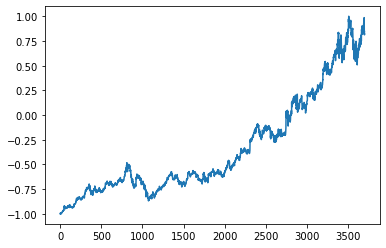

In [7]:

plt.plot(price)

## Split training, validation and testing data

In [8]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = 100;
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

## RNN Model

In [9]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [10]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 40
test_epochs = 1

In [11]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [12]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

## Training code

In [13]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
gru= []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()   
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.46105459332466125
Epoch  1 MSE:  0.2519567906856537
Epoch  2 MSE:  0.14698882400989532
Epoch  3 MSE:  0.17667832970619202
Epoch  4 MSE:  0.09150364249944687
Epoch  5 MSE:  0.03669791296124458
Epoch  6 MSE:  0.03454126417636871
Epoch  7 MSE:  0.026422690600156784
Epoch  8 MSE:  0.013187729753553867
Epoch  9 MSE:  0.037046462297439575
Epoch  10 MSE:  0.0346723273396492
Epoch  11 MSE:  0.009588144719600677
Epoch  12 MSE:  0.0031201147940009832
Epoch  13 MSE:  0.009245290420949459
Epoch  14 MSE:  0.01307068020105362
Epoch  15 MSE:  0.011653123423457146
Epoch  16 MSE:  0.009057017974555492
Epoch  17 MSE:  0.009332147426903248
Epoch  18 MSE:  0.011952986009418964
Epoch  19 MSE:  0.012546109966933727
Epoch  20 MSE:  0.008984056301414967
Epoch  21 MSE:  0.004117652773857117
Epoch  22 MSE:  0.001647014170885086
Epoch  23 MSE:  0.002114771632477641
Epoch  24 MSE:  0.0034433845430612564
Epoch  25 MSE:  0.0037642563693225384
Epoch  26 MSE:  0.0031424532644450665
Epoch  27 MSE:  0.

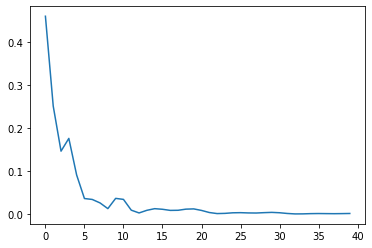

In [14]:
plt.plot(hist)

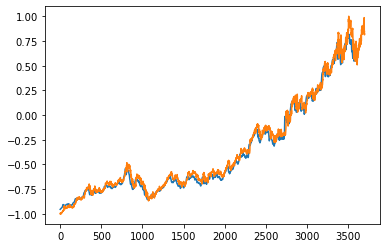

In [15]:
tense = y_train_pred
train_array = tense.detach().numpy()

plt.plot(train_array)
plt.plot(price)

## Testing code

Epoch  0 MSE:  0.007537251338362694


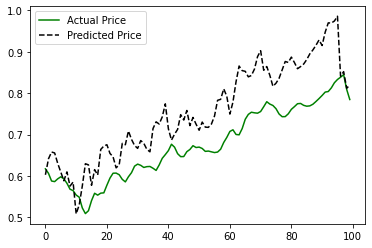

In [16]:
import time
hist = np.zeros(test_epochs)
start_time = time.time()
gru= []
for t in range(test_epochs):
    y_test_pred = model(x_test)
    loss = criterion(y_test_pred, y_test_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()   

tense_test = y_test_pred
test_array = tense_test.detach().numpy()
test_price = price[-100:]


plt.plot(test_array, 'g', label= 'Actual Price')
plt.plot(test_price['Open'].values, 'k--', label = 'Predicted Price')
plt.legend()